<a href="https://colab.research.google.com/github/Darshit1617/Phishing_domain_detector/blob/main/test05_phishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost scikit-learn pandas numpy matplotlib seaborn tldextract urllib3 whois python-whois requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 6.2 MB/s eta 0:00:00


# **Installing Required Packages & Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse
import tldextract
import whois
from datetime import datetime
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier

# **Loading Dataset**

In [3]:
# Set file paths - replace with your actual file paths
print("Enter dataset location for ranked domains:")
ranked_domains_path = input()  # e.g., "/content/ranked_domains.csv"

print("Enter dataset location for phishing URLs:")
phishing_urls_path = input()  # e.g., "/content/phishing_site_urls.csv"

# Load the datasets
ranked_domains_df = pd.read_csv(ranked_domains_path)
phishing_urls_df = pd.read_csv(phishing_urls_path)

# Display the first few rows of each dataset
print("Top Ranked Domains:")
print(ranked_domains_df.head())
print("\nPhishing URLs Dataset:")
print(phishing_urls_df.head())

# Check for missing values
print("\nMissing values in Ranked Domains:")
print(ranked_domains_df.isnull().sum())
print("\nMissing values in Phishing URLs:")
print(phishing_urls_df.isnull().sum())

Enter dataset location for ranked domains:
/content/ranked_domains.csv
Enter dataset location for phishing URLs:
/content/phishing_site_urls.csv
Top Ranked Domains:
   Rank         Domain
0     1    youtube.com
1     2   facebook.com
2     3  wikipedia.org
3     4     tiktok.com
4     5  instagram.com

Phishing URLs Dataset:
                                                 URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad

Missing values in Ranked Domains:
Rank      0
Domain    0
dtype: int64

Missing values in Phishing URLs:
URL      0
Label    0
dtype: int64


# **Preprocessing & Feature Engineering**


In [4]:
def extract_features(url):
    """Extract features from a URL"""
    features = {}

    # Parse the URL
    parsed_url = urlparse(url)
    extracted = tldextract.extract(url)
    domain = extracted.domain + '.' + extracted.suffix if extracted.suffix else extracted.domain

    # Length-based features
    features['url_length'] = len(url)
    features['domain_length'] = len(domain)

    # URL structure features
    features['num_dots'] = url.count('.')
    features['num_hyphens'] = url.count('-')
    features['num_underscores'] = url.count('_')
    features['num_slashes'] = url.count('/')
    features['num_question_marks'] = url.count('?')
    features['num_equal_signs'] = url.count('=')
    features['num_at_signs'] = url.count('@')
    features['num_ampersands'] = url.count('&')
    features['num_exclamation'] = url.count('!')
    features['num_tildes'] = url.count('~')
    features['num_percent'] = url.count('%')
    features['num_plus'] = url.count('+')
    features['num_asterisks'] = url.count('*')
    features['num_hash'] = url.count('#')
    features['num_dollar_signs'] = url.count('$')

    # Domain-specific features
    features['has_ip_address'] = 1 if re.match(r'\d+\.\d+\.\d+\.\d+', domain) else 0
    features['has_https'] = 1 if parsed_url.scheme == 'https' else 0
    features['has_www'] = 1 if extracted.subdomain == 'www' else 0
    features['subdomain_length'] = len(extracted.subdomain)
    features['num_subdomains'] = len(extracted.subdomain.split('.')) if extracted.subdomain else 0

    # Path-specific features
    features['path_length'] = len(parsed_url.path)
    features['has_suspicious_words'] = 1 if re.search(r'(login|signin|verify|secure|account|password|credential|confirm)', url.lower()) else 0

    # Query parameters
    features['num_params'] = len(parsed_url.query.split('&')) if parsed_url.query else 0

    return features

# Create an expanded function to add domain reputation features
def add_domain_reputation(features_df, ranked_domains_df):
    # Create a list of top domains from the ranked domains dataset
    top_domains = ranked_domains_df['domains'].tolist()

    # Add a feature to indicate if the domain is in the top ranked domains
    def is_in_top_domains(url):
        extracted = tldextract.extract(url)
        domain = extracted.domain + '.' + extracted.suffix
        return 1 if domain in top_domains else 0

    # Apply the function to create a new feature
    features_df['in_top_domains'] = features_df['URL'].apply(is_in_top_domains)

    return features_df

# **Feature Extraction & Combining two dataset**

In [6]:
# First, let's check the actual column names in the ranked domains dataframe
print("Ranked domains dataframe columns:", ranked_domains_df.columns.tolist())

# Create a dataframe with features for the phishing URLs dataset
def create_features_dataframe(urls_df, label_column=None):
    # Create an empty list to store the features
    features_list = []

    # Extract features for each URL
    for idx, row in urls_df.iterrows():
        url = row['URL']
        features = extract_features(url)

        # Add the URL to the features dictionary
        features['URL'] = url

        # Add the label if provided
        if label_column is not None:
            features['Label'] = row[label_column]

        features_list.append(features)

    # Convert the list of dictionaries to a DataFrame
    features_df = pd.DataFrame(features_list)

    return features_df

# Modified function to adapt to actual column names
def add_domain_reputation(features_df, ranked_domains_df):
    # Check which column contains domain information
    domain_column = None
    possible_names = ['domains', 'domain', 'website', 'url', 'site']

    for col in ranked_domains_df.columns:
        if col.lower() in possible_names:
            domain_column = col
            break

    if domain_column is None:
        # If no matching column found, use the second column (index 1)
        # Typically rank is the first column and domain is the second
        if len(ranked_domains_df.columns) >= 2:
            domain_column = ranked_domains_df.columns[1]
        else:
            domain_column = ranked_domains_df.columns[0]

    print(f"Using column '{domain_column}' from ranked domains dataset")

    # Create a list of top domains from the ranked domains dataset
    top_domains = ranked_domains_df[domain_column].tolist()

    # Add a feature to indicate if the domain is in the top ranked domains
    def is_in_top_domains(url):
        extracted = tldextract.extract(url)
        domain = extracted.domain + '.' + extracted.suffix
        return 1 if domain in top_domains else 0

    # Apply the function to create a new feature
    features_df['in_top_domains'] = features_df['URL'].apply(is_in_top_domains)

    return features_df

# Create feature dataframe for the phishing URLs dataset
phishing_features_df = create_features_dataframe(phishing_urls_df, 'Label')

# Add domain reputation features
phishing_features_df = add_domain_reputation(phishing_features_df, ranked_domains_df)

# Display the features dataframe
print("Features DataFrame:")
print(phishing_features_df.head())
print("\nFeatures DataFrame Shape:", phishing_features_df.shape)
print("\nFeatures list:", phishing_features_df.columns.tolist())

Ranked domains dataframe columns: ['Rank', 'Domain']
Using column 'Domain' from ranked domains dataset
Features DataFrame:
   url_length  domain_length  num_dots  num_hyphens  num_underscores  \
0         225              9         6            4                4   
1          81             11         5            2                1   
2         177             16         7            1                0   
3          60             13         6            0                0   
4         116             19         1            1                0   

   num_slashes  num_question_marks  num_equal_signs  num_at_signs  \
0           10                   1                4             0   
1            4                   0                2             0   
2           11                   0                0             0   
3            2                   0                0             0   
4           10                   1                0             0   

   num_ampersands  ...  has_h

# **Exploratory Data Analysis (EDA)**

Feature Statistics:
          url_length  domain_length       num_dots    num_hyphens  \
count  549346.000000  549346.000000  549346.000000  549346.000000   
mean       50.736288      13.676135       2.062316       1.126461   
std        44.418080       4.678714       1.514629       2.424343   
min         1.000000       0.000000       0.000000       0.000000   
25%        29.000000      11.000000       1.000000       0.000000   
50%        40.000000      13.000000       2.000000       0.000000   
75%        59.000000      16.000000       2.000000       1.000000   
max      2307.000000     151.000000      37.000000      42.000000   

       num_underscores    num_slashes  num_question_marks  num_equal_signs  \
count    549346.000000  549346.000000       549346.000000    549346.000000   
mean          0.390845       2.445168            0.161390         0.278629   
std           1.317131       1.595707            0.512545         0.956683   
min           0.000000       0.000000         

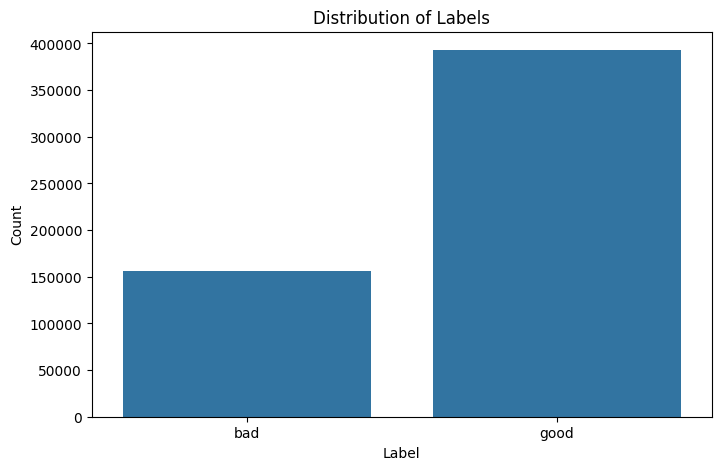

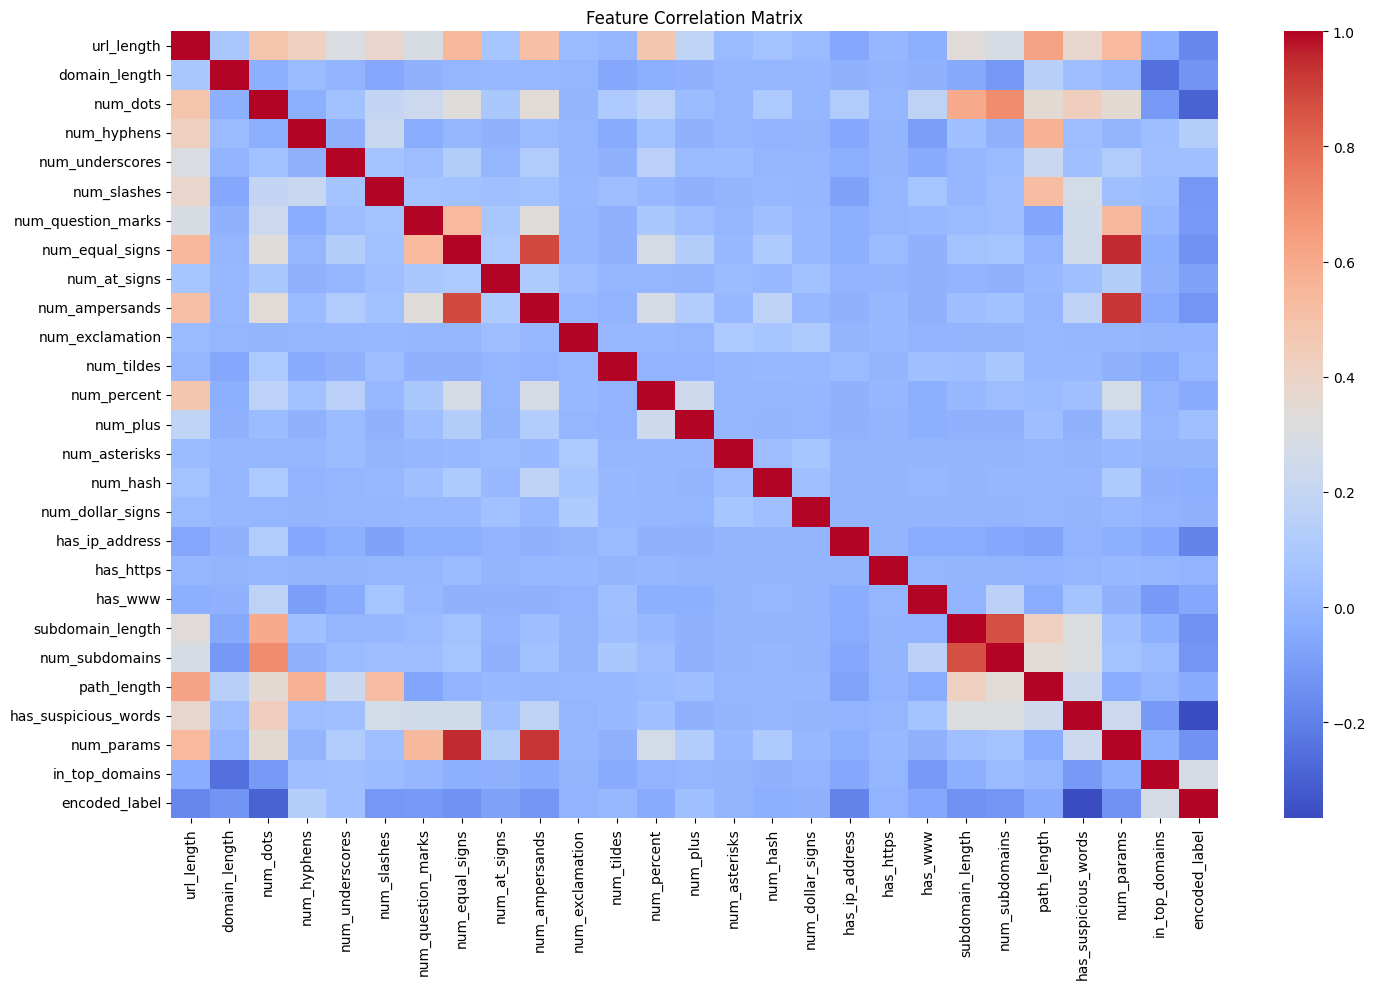

<Figure size 640x480 with 0 Axes>

In [16]:
# Basic statistics of the features
print("Feature Statistics:")
print(phishing_features_df.describe())

# Distribution of labels
print("\nLabel Distribution:")
label_counts = phishing_features_df['Label'].value_counts()
print(label_counts)

# Visualize the distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Label', data=phishing_features_df)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Analyze feature correlations
plt.figure(figsize=(15, 10))
correlation_matrix = phishing_features_df.drop(['URL', 'Label'], axis=1).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

# **Label encoding & Preparing training data**

In [8]:
# Prepare the data for model training
# Encode the labels
le = LabelEncoder()
phishing_features_df['encoded_label'] = le.fit_transform(phishing_features_df['Label'])
print("Label Encoding Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Separate features and target
X = phishing_features_df.drop(['URL', 'Label', 'encoded_label'], axis=1)
y = phishing_features_df['encoded_label']

# Display the shape of X and y
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature names:", X.columns.tolist())

Label Encoding Mapping: {'bad': 0, 'good': 1}
X shape: (549346, 26)
y shape: (549346,)
Feature names: ['url_length', 'domain_length', 'num_dots', 'num_hyphens', 'num_underscores', 'num_slashes', 'num_question_marks', 'num_equal_signs', 'num_at_signs', 'num_ampersands', 'num_exclamation', 'num_tildes', 'num_percent', 'num_plus', 'num_asterisks', 'num_hash', 'num_dollar_signs', 'has_ip_address', 'has_https', 'has_www', 'subdomain_length', 'num_subdomains', 'path_length', 'has_suspicious_words', 'num_params', 'in_top_domains']


# **Training and Test split**

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels distribution:", pd.Series(y_train).value_counts())
print("Testing labels distribution:", pd.Series(y_test).value_counts())

Training data shape: (412009, 26)
Testing data shape: (137337, 26)
Training labels distribution: encoded_label
1    294693
0    117316
Name: count, dtype: int64
Testing labels distribution: encoded_label
1    98231
0    39106
Name: count, dtype: int64


# **Model training and Hyperparameter tuning**

<Figure size 1200x800 with 0 Axes>

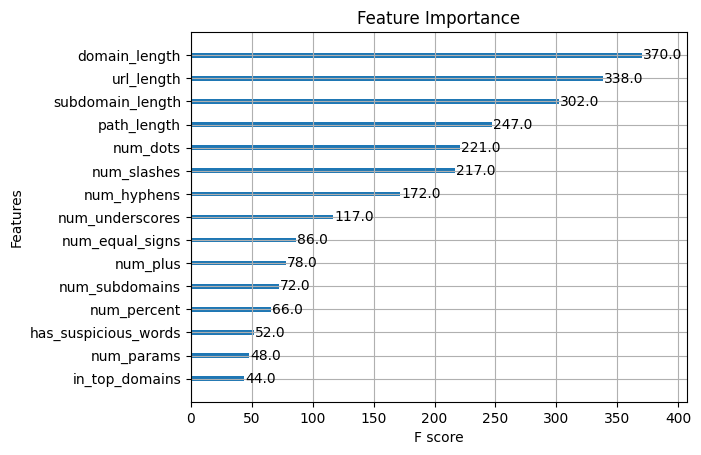

In [10]:
# Train an XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Display feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Feature Importance')
plt.show()

# **Model evaluation**

Accuracy: 0.8382

Classification Report:
              precision    recall  f1-score   support

         bad       0.90      0.48      0.63     39106
        good       0.83      0.98      0.90     98231

    accuracy                           0.84    137337
   macro avg       0.86      0.73      0.76    137337
weighted avg       0.85      0.84      0.82    137337



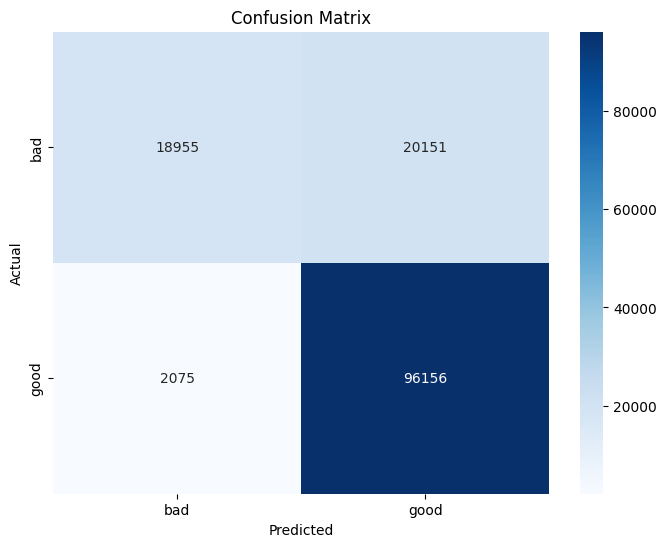

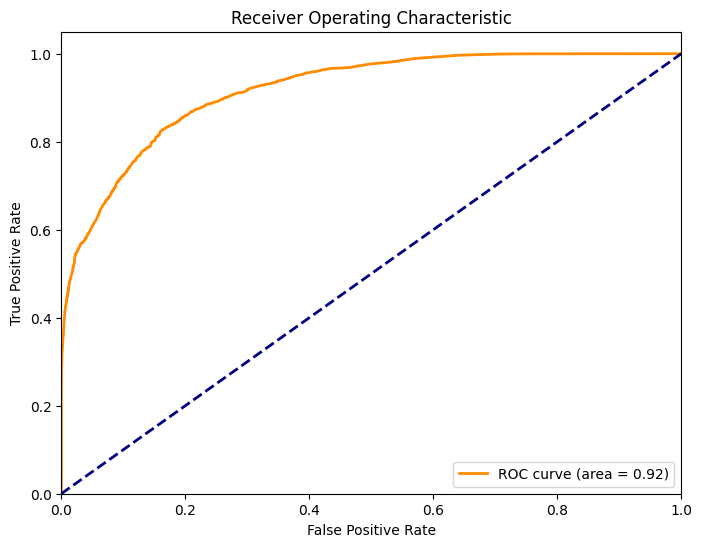

In [11]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# **Save a model**

In [12]:
# Save the model and label encoder for later use
import pickle

# Save the model
with open('phishing_detector_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and label encoder saved successfully.")

Model and label encoder saved successfully.


# **UI for URL Prediction**

In [14]:
# Function to predict a single URL
def predict_url(url, model, label_encoder):
    # Extract features from the URL
    features = extract_features(url)

    # Convert to DataFrame for consistency
    features_df = pd.DataFrame([features])

    # Determine which column in ranked_domains_df contains domains
    domain_column = None
    possible_names = ['domains', 'domain', 'website', 'url', 'site']

    for col in ranked_domains_df.columns:
        if col.lower() in possible_names:
            domain_column = col
            break

    if domain_column is None:
        # If no matching column found, use the second column (index 1)
        if len(ranked_domains_df.columns) >= 2:
            domain_column = ranked_domains_df.columns[1]
        else:
            domain_column = ranked_domains_df.columns[0]

    # Add domain reputation feature
    extracted = tldextract.extract(url)
    domain = extracted.domain + '.' + extracted.suffix
    features_df['in_top_domains'] = 1 if domain in ranked_domains_df[domain_column].values else 0

    # Make sure the DataFrame has all the features used during training
    for col in X.columns:
        if col not in features_df.columns:
            features_df[col] = 0

    # Keep only the features used during training and in the same order
    features_df = features_df[X.columns]

    # Make prediction
    prediction = model.predict(features_df)[0]
    probability = model.predict_proba(features_df)[0][prediction]

    # Convert prediction to label
    label = label_encoder.inverse_transform([prediction])[0]

    return {
        'url': url,
        'prediction': label,
        'probability': probability,
        'safe': label == 'good'
    }

# **Simple Web Interface with Gradio**

In [15]:
# Install Gradio
!pip install gradio

import gradio as gr

# Define the prediction function for Gradio
def predict_phishing(url):
    # Add http:// prefix if not present
    if not url.startswith('http://') and not url.startswith('https://'):
        url = 'http://' + url

    try:
        result = predict_url(url, xgb_model, le)

        if result['safe']:
            return f"✅ The URL is safe. (Confidence: {result['probability']*100:.2f}%)"
        else:
            return f"❌ The URL is not safe. There is a threat of phishing/malware attack. (Confidence: {result['probability']*100:.2f}%)"
    except Exception as e:
        return f"Error analyzing the URL: {str(e)}"

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_phishing,
    inputs=gr.Textbox(placeholder="Enter a URL..."),
    outputs=gr.Textbox(),
    title="Phishing URL Detector",
    description="Enter a URL to check if it's a potential phishing site."
)

# Launch the interface
iface.launch(share=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e7fced55b20ef3874f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces